In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from lmmnn.utils import generate_data

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

In [4]:
def get_model(input_dim, patience):
    model = Sequential()
    model.add(Dense(100, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    callbacks = [EarlyStopping(monitor='val_loss', patience=patience)]
    return model, callbacks

In [28]:
max_iterations = 100
n_clusters = 10
sig2e = 1.0
sig2b = 1.0
N = 1000
params = {
    'n_fixed_effects': 10,
    'n_per_cat': 3,
    'fixed_intercept': 1,
    'X_non_linear': True,
    'Z_non_linear': False,
    'Z_embed_dim_pct': 10,
    'patience': 10
}

In [6]:
X_train, X_test, y_train, y_test, x_cols = generate_data(n_clusters, sig2e, sig2b, N, params)

In [7]:
X_train.shape

(800, 11)

In [8]:
x_cols

['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']

In [9]:
cnt_clusters = X_train.groupby('z').size().values

In [10]:
X = X_train[x_cols].values
# Z = X
clusters = X_train['z'].values
y = y_train.values
n_obs = X.shape[0]

In [12]:
nll_history = np.zeros(max_iterations)
maps2ind = [list(np.where(clusters == i)[0]) for i in range(n_clusters)]
# b_hat_history = list()
# lf_history = list()

In [13]:
model, callbacks = get_model(params['n_fixed_effects'], params['patience'])

In [22]:
f = K.function([model.layers[0].input], [model.layers[-2].output])

In [25]:
f(X)[0].shape

(800, 12)

In [26]:
Z = f(X)[0]

In [27]:
q = Z.shape[1]
D_hat = np.eye(q)
sig2e_hat = 1
b_hat_df = np.zeros((n_clusters, q))

In [29]:
for iteration in range(max_iterations):
    print(f'iteration: {iteration}')
    y_star = np.zeros(y.shape)
    for cluster_id in range(n_clusters):
        indices_i = maps2ind[cluster_id]
        b_hat_i = b_hat_df[cluster_id, :]
        y_star_i = y[indices_i] - Z[indices_i, :] @ b_hat_i
        y_star[indices_i] = y_star_i
    # lf = LinearRegression().fit(X, y_star)
    # f_hat = lf.predict(X)
    model.fit(X, y_star, batch_size = 30, epochs=1, verbose=0)
    Z = f(X)[0]
    f_hat = model.predict(X, verbose=0).reshape(X.shape[0])
    sig2e_hat_sum = 0
    D_hat_sum = 0
    for cluster_id in range(n_clusters):
        indices_i = maps2ind[cluster_id]
        n_i = cnt_clusters[cluster_id]
        f_hat_i = f_hat[indices_i]
        y_i = y[indices_i]
        Z_i = Z[indices_i, :]
        V_hat_i = Z_i @ D_hat @ np.transpose(Z_i) + sig2e_hat * np.eye(n_i)
        V_hat_inv_i =  np.linalg.inv(V_hat_i)
        b_hat_i = D_hat @ np.transpose(Z_i) @ V_hat_inv_i @ (y_i - f_hat_i)
        eps_hat_i = y_i - f_hat_i - Z_i @ b_hat_i
        b_hat_df[cluster_id, :] = b_hat_i
        sig2e_hat_sum = sig2e_hat_sum + np.transpose(eps_hat_i) @ eps_hat_i + sig2e_hat * (n_i - sig2e_hat * np.trace(V_hat_inv_i))
        D_hat_sum = D_hat_sum + b_hat_i @ np.transpose(b_hat_i) + (D_hat - D_hat @ np.transpose(Z_i) @ V_hat_inv_i @ Z_i @ D_hat)
    sig2e_hat = sig2e_hat_sum / n_obs
    D_hat = D_hat_sum / n_clusters
    # b_hat_history.append(b_hat_df)
    nll = 0
    for cluster_id in range(n_clusters):
        indices_i = maps2ind[cluster_id]
        n_i = cnt_clusters[cluster_id]
        y_i = y[indices_i]
        Z_i = Z[indices_i, :]
        I_i = np.eye(n_i)
        f_hat_i = f_hat[indices_i]
        R_hat_i = sig2e_hat * I_i
        b_hat_i = b_hat_df[cluster_id, :]
        nll = nll + np.transpose(y_i - f_hat_i - Z_i @ b_hat_i) @ np.linalg.inv(R_hat_i) @ (y_i - f_hat_i - Z_i @ b_hat_i) + \
            b_hat_i @ np.linalg.inv(D_hat) @ b_hat_i + np.log(np.linalg.det(D_hat)) + np.log(np.linalg.det(R_hat_i))
    nll_history[iteration] = nll

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

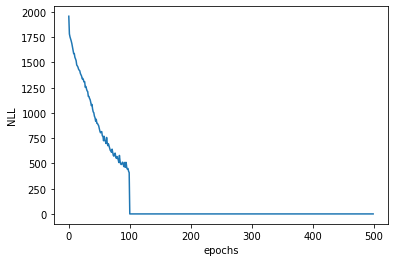

In [30]:
plt.plot(nll_history)
plt.ylabel('NLL')
plt.xlabel('epochs')
plt.show()

In [31]:
X2 = X_test[x_cols].values
Z2 = f(X2)[0]
clusters2 = X_test['z'].values
y2 = y_test.values

In [32]:
# y_hat_fix = lf.predict(X2)
y_hat_fix = model.predict(X2).reshape(X2.shape[0])
y_hat = y_hat_fix

In [33]:
for cluster_id in range(n_clusters):
    indices_i = np.where(clusters2 == cluster_id)[0]
    if len(indices_i) == 0:
        continue
    b_i = b_hat_df[cluster_id, :]
    Z_i = Z2[indices_i, :]
    y_hat[indices_i] = y_hat[indices_i] + Z_i @ b_i

In [34]:
lim_min, lim_max = np.min([np.min(y2), np.min(y_hat)]), np.max([np.max(y2), np.max(y_hat)])

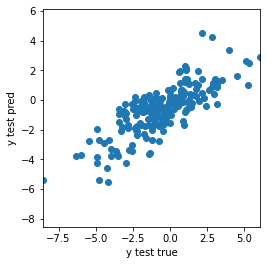

In [35]:
plt.scatter(y2, y_hat)
plt.xlim(lim_min, lim_max)
plt.ylim(lim_min, lim_max)
plt.xlabel('y test true')
plt.ylabel('y test pred')
plt.gca().set_aspect('equal')
plt.draw()
plt.show()

In [36]:
sig2e_hat

0.9467031076801439

In [37]:
nll_history[-10:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])